In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pylab as plt  # https://stackoverflow.com/questions/16849483/which-is-the-recommended-way-to-plot-matplotlib-or-pylab
import random
from scipy import stats

In [2]:
## DATA ##

file_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastspec-everest-main-bright.fits"
data=Table.read(file_path,hdu=1)
#data

In [3]:
N=data["TARGETID"].size  # https://learnpython.com/blog/python-case-sensitive/
snr=np.zeros(N)
for i in range(N):
    snr[i]=data["HALPHA_EW"][i]*np.sqrt(data["HALPHA_EW_IVAR"][i]) 

/tmp/ipykernel_27573/1161717480.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(data["HALPHA_EW"],1/np.sqrt(data["HALPHA_EW_IVAR"]),'*',alpha=0.1)


(0.0, 2000.0)

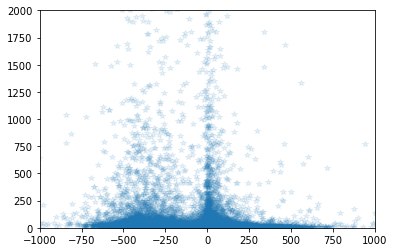

In [41]:
plt.plot(data["HALPHA_EW"],1/np.sqrt(data["HALPHA_EW_IVAR"]),'*',alpha=0.1)
plt.xlim((-1000,1000))
plt.ylim((0,2000))

In [14]:
## getting good data of size n
file_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastphot-everest-main-bright.fits"
data2=Table.read(file_path,hdu=1)
n=5*10**3
positions=[]
for i in range(N):
    k=0
    if data["HALPHA_EW"][i]<=5 or snr[i]<=20:
        k+=1
    if data2["KCORR_SDSS_U"][i]==0:
        k+=1
    if k==0:
        positions.append(i)
print(len(positions))

#magnitude_names=["FLUX_SYNTH_MODEL_G","FLUX_SYNTH_MODEL_R","FLUX_SYNTH_MODEL_Z","FLUX_SYNTH_MODEL_W1","FLUX_SYNTH_MODEL_W2"]
magnitude_names=["KCORR_SDSS_U","KCORR_SDSS_G","KCORR_SDSS_R","KCORR_SDSS_I","KCORR_SDSS_Z"]
#jj=random.sample(range(0,len(positions)),n)
jj=np.arange(n)
EW=np.zeros(n)
magnitudes=np.zeros([n,len(magnitude_names)])

for i in range(n):
    EW[i]=np.log10(data["HALPHA_EW"][positions[jj[i]]])
    for j in range(len(magnitude_names)):
        magnitudes[i,j]=data2[magnitude_names[j]][positions[jj[i]]]
# av_mag=np.zeros(len(magnitude_names))
# std_mag=np.zeros(len(magnitude_names))
# for j in range(len(magnitude_names)):
#     av_mag[j]=np.average(magnitudes[:,j])
#     std_mag[j]=np.std(magnitudes[:,j])
#     magnitudes[:,j]=(magnitudes[:,j]-av_mag[j])/std_mag[j]

684652


In [30]:
## doing local linear regression
ones=np.ones([n,1])
#x=np.concatenate((ones,magnitudes),axis=1)
x=np.zeros([n,len(magnitude_names)-1])
for i in range(n):
    for j in range(len(magnitude_names)-1):
        x[i,j]=magnitudes[i,j]-magnitudes[i,j+1]
x=np.concatenate((ones,x),axis=1)
av_x=np.zeros(x.shape[1]-1)
std_x=np.zeros(x.shape[1]-1)
for i in range(1,x.shape[1]):
    av_x[i-1]=np.average(x[:,i])
    std_x[i-1]=np.std(x[:,i])
    x[:,i]=(x[:,i]-av_x[i-1])/std_x[i-1]
theta=[]
i_working=[]
nl=30 # nearest neighbor number
w_nearest=np.zeros(n)
w_nl=np.zeros(n)
for i in range(n):
    w=np.zeros(n)
    for j in range(n):
        if j!=i:
            distance=np.linalg.norm(x[i,:]-x[j,:])**2
            w[j]=1/distance
            if 1/distance!=1/distance:
                print(i,j)
    w[i]=max(w)
    w_sorted=np.sort(w)
    w_sorted = w_sorted[::-1]
    positions_nbrs=np.argsort(w)
    positions_nbrs=positions_nbrs[::-1]
    w_nearest[i]=w_sorted[0]
    w_nl[i]=w_sorted[nl-1]
    # if w_sorted[nl-1]<1:
    #     continue 
    i_working.append(i)
    W=np.zeros([nl,nl])
    X=np.zeros([nl,x.shape[1]])
    Y=np.zeros([nl,1])
    for j in range(nl):
        #W[j,j]=1
        #W[j,j]=np.sqrt(w[positions_nbrs[j]])
        W[j,j]=w[positions_nbrs[j]]
        X[j,:]=x[positions_nbrs[j],:]
        Y[j,:]=EW[positions_nbrs[j]]
    a1=np.matmul(X.transpose(),np.matmul(W,Y))
    a2=np.matmul(X.transpose(),np.matmul(W,X))
    theta1=np.matmul(np.linalg.inv(a2),a1)
    theta.append(theta1)
    
print(len(i_working))


5000


In [7]:
# np.savetxt("w_nearest_mag.txt",w_nearest,delimiter=',')
# np.savetxt("w_nl_mag.txt",w_nl,delimiter=',')


0.8786569598548228 0.8748520988870804 0.16472789175045746


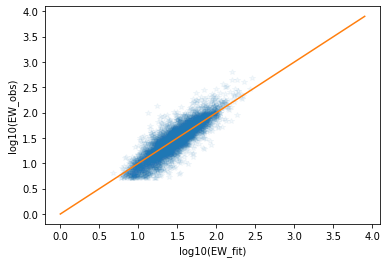

In [31]:
## plotting EWs

n_used=len(i_working)
EW_test=np.zeros(n_used)
EW_used=np.zeros(n_used)
for i in range(n_used):
    EW_test[i]=np.matmul(theta[i].transpose(),x[i_working[i],:])
    EW_used[i]=EW[i_working[i]]


plt.plot(EW_test,EW_used,'*',alpha=0.05)
plt.plot(np.arange(0,4,0.1),np.arange(0,4,0.1))
plt.xlabel("log10(EW_fit)")
plt.ylabel("log10(EW_obs)")
# plt.xlim((0,4))
# plt.ylim((0,4))
std=np.std(EW_used)
std_test=np.std(EW_test)
av=np.average(EW_used)
av_test=np.average(EW_test)
r=0
rms=0
for i in range(n_used):
    r+=(EW_used[i]-av)*(EW_test[i]-av_test)/(n_used**1*std*std_test)
    rms+=(EW_used[i]-EW_test[i])**2/n_used
rms=np.sqrt(rms)
spearman=stats.spearmanr(EW_test,EW_used)
print(r,spearman[0],rms)

In [32]:
np.savetxt("EW_test_distance_squared.txt",EW_test,delimiter=',')
np.savetxt("EW_used_distance_squared.txt",EW_used,delimiter=',')

0.9589183210232758
[ 1.         -1.85451164  0.60808331  0.86306596 -1.31543676]


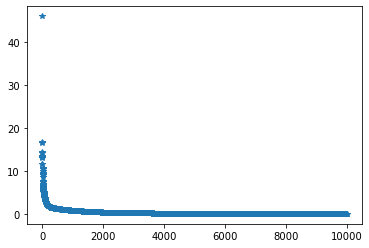

In [10]:
## These are all some testing I did for debugging etc.

i=182
print(EW_test[i])
print(x[i,:])

w=[]
for j in range(n):
    if j!=i:
        distance=np.linalg.norm(x[i,:]-x[j,:])**2
        w.append(1/distance)
w_sorted=np.array(w)
w_sorted=np.sort(w_sorted)
w_sorted = w_sorted[::-1]
positions_nbrs=np.zeros(nl,int)
W=np.zeros([nl,nl])
X=np.zeros([nl,x.shape[1]])
Y=np.zeros([nl,1])
for j in range(nl):
    positions_nbrs[j]=np.where(w==w_sorted[j])[0][0]
    W[j,j]=w[positions_nbrs[j]]
    X[j,:]=x[positions_nbrs[j],:]
    Y[j,:]=EW[positions_nbrs[j]]
a1=np.matmul(X.transpose(),np.matmul(W,Y))
a2=np.matmul(X.transpose(),np.matmul(W,X))
theta1=np.matmul(np.linalg.inv(a2),a1)

plt.figure(1)
plt.plot(w_sorted[:],'*')

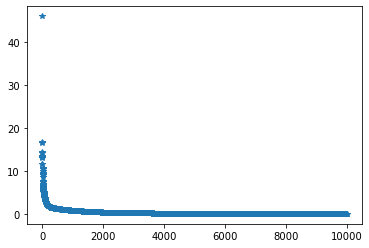

In [11]:
plt.plot(w_sorted,'*')